In [14]:
!pip install fastdtw
!pip install imblearn

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, recall_score
from urllib.request import urlopen
from io import StringIO
from google.colab import drive
import random
from imblearn.metrics import specificity_score
from imblearn.over_sampling import BorderlineSMOTE

In [16]:
# 1. Google Drive 마운트 및 데이터 파일 경로 설정
drive.mount('/content/drive')
df_X_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/X_train_sample.csv')
df_y_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/y_train_sample.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/X_test_sample.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/y_test_sample.csv')

X_train = df_X_train.values
y_train = df_y_train.values.reshape(-1)
X_test = df_X_test.values
y_test = df_y_test.values.reshape(-1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Apply Borderline SMOTE to balance the dataset
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [18]:
# 3. DTW 거리 행렬 계산 함수 정의 (1D 벡터 변환 추가)
def compute_dtw_matrix(X1, X2):
    """X1과 X2 간의 DTW 거리 행렬을 계산"""
    n1, n2 = len(X1), len(X2)
    dtw_matrix = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            distance, _ = fastdtw(X1[i].reshape(-1, 1), X2[j].reshape(-1, 1), dist=euclidean)
            dtw_matrix[i, j] = distance
    return dtw_matrix

In [19]:
# 4. DTW 거리 행렬 계산
print("Computing DTW distance matrix for training data...")
train_dtw_matrix = compute_dtw_matrix(X_train_resampled, X_train_resampled)
print("Computing DTW distance matrix between train and test data...")
test_dtw_matrix = compute_dtw_matrix(X_test, X_train_resampled)

Computing DTW distance matrix for training data...
Computing DTW distance matrix between train and test data...


In [20]:
train_dtw_matrix.shape

(234, 234)

In [21]:
from sklearn.model_selection import train_test_split, cross_val_score
# train 점수
k_range = range(1, 21)  # K 값을 1부터 20까지 탐색
trainList = []
for k in k_range:
    # 모델 선택 및 하이퍼 파라미터 튜닝
    #model = KNeighborsClassifier(n_neighbors = k, metric='precomputed')
    model = KNeighborsClassifier(n_neighbors = k, metric='precomputed')
    # 모델학습
    model.fit(train_dtw_matrix, y_train_resampled)
    scores = cross_val_score(model, train_dtw_matrix, y_train_resampled, cv=5, scoring='f1_macro')
    trainList.append(scores.mean())
optimal_score = trainList[np.argmax(trainList)]
optimal_k = np.argmax(trainList)+1
print(f"최적의 K 값: {optimal_k}")
print(f"최적의 K 값의 성능: {optimal_score}")

최적의 K 값: 1
최적의 K 값의 성능: 0.9743907332114018


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

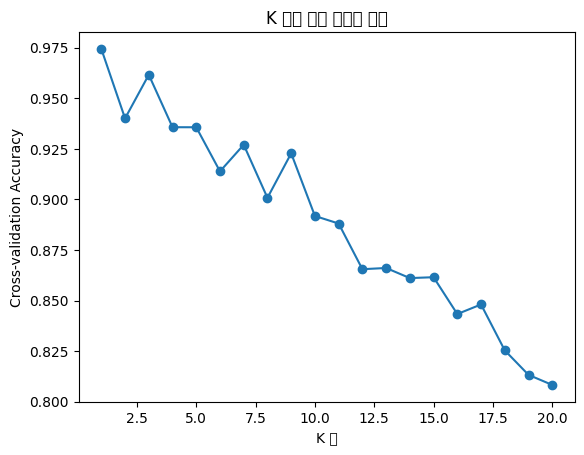

In [22]:
# K 값에 따른 정확도 그래프
plt.plot(k_range, trainList, marker='o')
plt.xlabel("K 값")
plt.ylabel("Cross-validation Accuracy")
plt.title("K 값에 따른 정확도 변화")
plt.show()

In [23]:
# 최적 K 값으로 최종 KNN 모델 학습 및 평가
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, metric='precomputed')
knn_optimal.fit(train_dtw_matrix, y_train_resampled)
y_pred = knn_optimal.predict(test_dtw_matrix)

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_recall_curve

In [25]:
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred)
specificity = specificity_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"specificity: {specificity:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6118
F1 Score: 0.4944
Recall: 0.9804
specificity: 0.0588
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.06      0.11        34
           1       0.61      0.98      0.75        51

    accuracy                           0.61        85
   macro avg       0.64      0.52      0.43        85
weighted avg       0.63      0.61      0.49        85



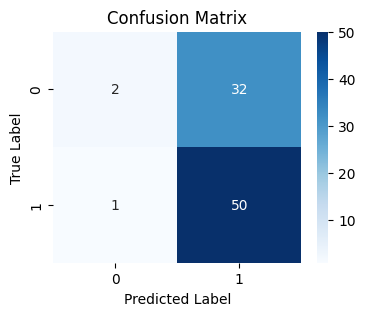

In [26]:
# Confusion Matrix
plt.figure(figsize=(4, 3))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()